# Ejemplo de una Regresión Lineal usando Inferencia Variacional
***
Referencia: Probabilistic Deep Learning. With Python, Keras and TensorFlow Probability. Oliver Dürr, Beate Sick with Elvise Murina. Manning. 2020.

Ejemplo obtenido de: https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb

In [2]:
pip install tensorflow_probability

## Bibliotecas

In [3]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 15}) # Large Fonts

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.22.0
TF  Version 2.14.0


### Generación de datos
***

In [5]:
# Normal
n23 = tfd.Normal(2,3) # Distribución Normal
print('Normal (2,3) mu = ',n23.mean().numpy(),' sdtdev = ',n23.stddev().numpy())

Normal (2,3) mu =  2.0  sdtdev =  3.0


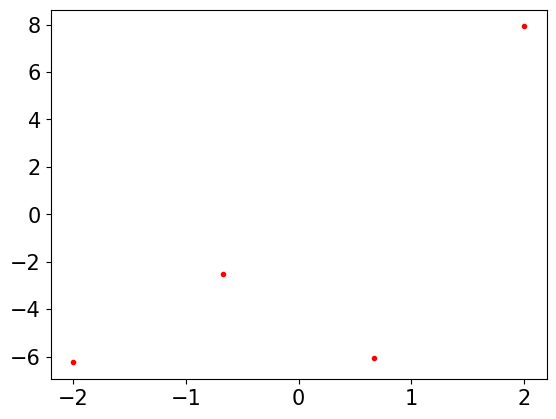

[[-2.        ]
 [-0.66666667]
 [ 0.66666667]
 [ 2.        ]] [-6.25027354 -2.50213382 -6.07525495  7.92081243]


In [9]:

np.random.seed(2) # inicialización semilla
num = 4 # cantidad de datos
sigma=3 # se fija el valor de sigma para los valores de y

bmin = -10; bmax = 8
amin = -3; amax = 8
xmin = -5; xmax = +5; ymin = -40; ymax=40;

x = np.linspace(-2,2,num=num).reshape((num,1))

y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) #np.random.normal: Extrae muestras aleatorias de una distribución normal (Gaussiana).

plt.scatter(x,y, marker='.', color='r')
plt.show()
print(x,y)

In [11]:
## Función para imprimir pesos
class Logger:
    """
        Writes out the weights, gradient, and losses.
    """
    def __init__(self, steps, num_weights = 4):
        self.steps = steps
        self.num_weights = num_weights
        self.X = np.zeros((steps, 12))
        self.header = 'epoch,w0,w1,w2,w3,wg0,wg1,wg2,wg3,loss,loss_kl,loss_mse'

    def log(self, step, epoch, w, w_grad, loss, loss_kl, loss_mse):
        n = self.num_weights
        self.X[step,0] = epoch
        self.X[step,1:(n+1)] = w.numpy()
        self.X[step,(n+1):((2*n)+1)] = w_grad.numpy()
        self.X[step,((2*n)+1)] = loss.numpy()
        self.X[step,((2*n)+2)] = loss_kl.numpy()
        self.X[step,((2*n)+3)] = loss_mse.numpy()


    def getX(self):
        return self.X

### Minimización de la función de pérdida usando VI
***
$\text{loss}_{\text{VI}} = \text{loss}_{\text{KL}} + \text{loss}_{\text{NLL}}  = \text{KL}[q_{\lambda}(\theta) || p(\theta) - E_{\theta \sim q_{\lambda}} [\log{p(D|\theta)}]]$




*   $\text{loss}_{\text{KL}}$ tiene solución analítica:
$$\text{loss}_{\text{KL}}=  \text{KL}[q_{\lambda}(\theta)||p(\theta)]  = \text{KL}[N(\mu,\sigma)||N(0,1)] = -\frac{1}{2}(1 + \log{(\sigma^2)} - \mu^2 -\sigma^2 )$$

*   $\text{loss}_{\text{NLL}}$ requiere calcular $E_{\theta \sim q_{\lambda}} [\log{p(D|\theta)}]$, lo que no es tan simple.


> *  Se puede aproximar el valor esperado con el promedio empírico promediando sobre $-\log{p(D|\theta)}]$ para diferentes $\theta$, que son muestreados de $\theta \sim q_{\lambda}$.
*¿Cuántos muestreos se necesitan? **Solo uno**.
* Se calcula NLL:
$$\log{(p(D|(a,b))}=\sum_{i=1}^{n}\log{(N(y_i;a \cdot x_i + b, \sigma))}$$
donde $N(y_i;a\cdot x_i + b, \sigma)$ es la función de densidad Normal.
* Para aproxima NNL, se muestrea un solo valor de $a$ y $b$
>
* Notar que la derivada de la pérdida con respecto al parámetro $\mu_a$, impliva cacular la derivada de la densidad $N(\mu_a, \sigma_a)$ con respecto a $\mu_a$, pero $a$ es un valor muestreado de una Gaussiana, por lo que no se puede porque $a$ es un valor aleatorio y no sabemos en que punto tomar la derivada de una función de densidad Normal.
* La soución es un **reparatmetrization trick**. En vez de muestrear $a\sim N(\mu_a, \sigma_a)$ se calcula $a_{\text{rep}} = \mu_a + \sigma_a \cdot \epsilon $ y se muestrea $\epsilon N(0,1)$ y se puede hacer backpropagation con respecto a $\sigma_a$ y $\mu_a$



In [12]:
epochs=10000
logger = Logger(epochs) #instanciación clase anterior
lr = 0.001
optimizer = tf.keras.optimizers.SGD(lr)

w_0=(1.,1.,1.,1.)  #vector de parámetros inicial, recordar que los parámetros
                   # son mu_a, sig_a,mu_b,sig_b

log = tf.math.log # Calcula el logaritmo natural de x elemento a elemento
w = tf.Variable(w_0) # Vector theta
e = tfd.Normal(loc=0., scale=1.) # ruido necesario para el "truco variacional"
ytensor = y.reshape([len(y),1]) #

for i in range(epochs):
    with tf.GradientTape() as tape:  #  para la diferenciación automática; es decir,
                                     #calcular el gradiente de un cálculo con respecto
                                     # a algunas entradas, generalmente tf.Variable

        mu_a = w[0]
        sig_a = tf.math.softplus(w[1]) # debe ser positivo, por eso se usa softplus

        mu_b= w[2]
        sig_b= tf.math.softplus(w[3]) # debe ser positivo, por eso se usa softplus

        # Solución analítica de la divergencia KL con priors Gaussianos
        l_kl = -0.5*(1.0 +
            log(sig_a**2) - sig_a**2 - mu_a**2 +
            1.0 + log(sig_b**2) - sig_b**2 - mu_b**2)

        a =  mu_a + sig_a * e.sample()  # Muestreo de a ~ N(mu_a, sig_a) con "reparametrization trick"
        b =  mu_b + sig_b * e.sample()  # Muestreo b ~ N(mu_b, sig_b)
        y_prob = tfd.Normal(loc=x*a+b, scale=sigma) # Distribución normal
        l_nll = -tf.reduce_sum(y_prob.log_prob(ytensor)) #Cálculo de la NNL

        loss = l_nll + l_kl
    grads = tape.gradient(loss, w) # derivadas de la función de pérdida con respecto a w
                                   # para actualizar los valores de w
    logger.log(i, i, w, grads, loss, l_kl, l_nll)
    w = tf.Variable(w - lr*grads)  # Paso del gradiente descendente

    if i % 2000 == 0 or i < 2:
        print(i, " loss ", loss.numpy(), " lr ", lr)
        print('a_mu', w[0].numpy(),'b_mu', w[2].numpy())

0  loss  15.31537  lr  0.001
a_mu 1.0004721 b_mu 0.99773896
1  loss  18.764645  lr  0.001
a_mu 1.0020931 b_mu 0.9951473
2000  loss  12.999676  lr  0.001
a_mu 1.442661 b_mu -0.45320216
4000  loss  13.36862  lr  0.001
a_mu 1.4668534 b_mu -0.51927084
6000  loss  13.736462  lr  0.001
a_mu 1.4264467 b_mu -0.54177725
8000  loss  16.898731  lr  0.001
a_mu 1.4634209 b_mu -0.5148051


## Loss plot

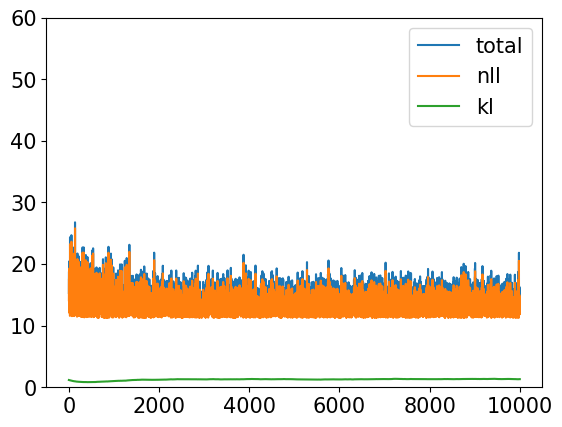

b =  1.6593245   0.70473385  a =  -0.5323213   0.83109844


In [13]:
W = logger.getX()
loss_history = W[:,9]
loss_history_nll = W[:,10]
loss_history_kl = W[:,11]
plt.plot(loss_history)
plt.plot(loss_history_kl)
plt.plot(loss_history_nll)
plt.legend(('total', 'nll', 'kl'))
plt.ylim(0,60)
plt.show()
print('b = ', tf.math.softplus(w[0]).numpy(), ' ', tf.math.softplus(w[1]).numpy(),
      ' a = ', w[2].numpy(), ' ',  tf.math.softplus(w[3]).numpy())

Text(0.5, 1.0, 'Convergencia de las soluciones')

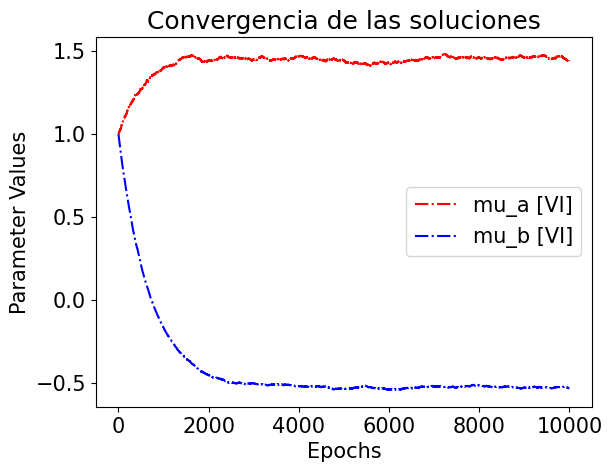

In [14]:
W = logger.getX()
weights = W[:,1:5]
epochs = W.shape[0]
from matplotlib.pyplot import figure

#slope a
plt.plot(weights[:,0],color='r',linestyle='-.')
plt.xlabel('Epochs')
plt.ylabel('Parameter Values')

plt.plot(weights[:,2],color='b', linestyle='-.')

plt.legend(('mu_a [VI]', 'mu_b [VI]'))

plt.title('Convergencia de las soluciones')
   # no plt.show() in previous line!

### Construcción de una Fully-Connected BNN

In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [16]:
def NLL(y, distr):#
    return -distr.log_prob(y)

def my_dist(mu): #
    return tfd.Normal(loc=mu[:,0:1], scale=sigma)

kl = tfp.distributions.kl_divergence
divergence_fn=lambda q, p, _: kl(q, p) / (num * 1.0) #B


model = tf.keras.Sequential([
    tfp.layers.DenseReparameterization(1, #Esta capa implementa la inferencia variacional bayesiana análoga a una capa densa
       kernel_divergence_fn=divergence_fn,
       bias_divergence_fn=divergence_fn,
       bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,
       bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn()
                                       ),
    tfp.layers.DistributionLambda(my_dist)
])


sgd = tf.keras.optimizers.SGD(lr=.005)
model.compile(loss=NLL, optimizer=sgd)


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Text(0, 0.5, 'Total loss')

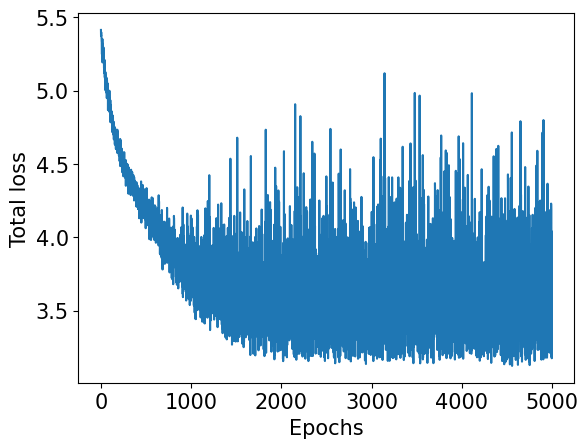

In [17]:
hist = model.fit(x, y, epochs=5000, batch_size=num, verbose=False)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Total loss')

In [18]:
wtfp = model.get_weights()

In [25]:
def sp(x):
    return np.log(1 + np.exp(x))**2

In [26]:
wtfp[0][0,0], sp(wtfp[1][[0]])[0,0],wtfp[2][0], sp(wtfp[3][[0]])[0]

(1.4392642, 0.52064043, -0.5288808, 0.7038652)

In [30]:
ww = w.numpy()
ww[0], sp(ww[1]), ww[2], sp(ww[3])

(1.4482733, 0.4966498328566925, -0.5323213, 0.6907246983189054)